# Multiple object tracker

##Primary task:

Create multiple person tracker based on YOLOv5 detector and SORT tracker.

* Download [MOT17](https://motchallenge.net/data/MOT17/) data for single video
* Read the video, draw ground true bounding boxes along track id (in green color) and save new video in file output.mp4. 
* Create class person detector based on [YOLOv5](https://pytorch.org/hub/ultralytics_yolov5/) model for obtain bounding boxes
* Create instance of [SORT](https://arxiv.org/abs/1602.00763) class to obtain track_id for every detected bounding box
* Append new bounding boxes along track id (in red color) to video in output.mp4. 


## Secondary task

Measure overall speed of your tracker in FPS (Frame per second)







###Download MOT17 data and labels

In [1]:
# Full data splitted by frames
# Really  we don't need it for this task but some images will be used for tests
!wget https://motchallenge.net/data/MOT17Det.zip
!unzip MOT17Det.zip

# Ground true bounding box
!wget https://motchallenge.net/data/MOT17Labels.zip
!unzip MOT17Labels.zip

# File with wideo
# Warning video resolution in this copy smaller than original video
!wget https://motchallenge.net/sequenceVideos/MOT17-09-SDP-raw.webm

in_video = 'content/MOT17-09-SDP-raw.webm'

Streaming output truncated to the last 5000 lines.
  inflating: train/MOT17-02/img1/000451.jpg  
  inflating: train/MOT17-02/img1/000452.jpg  
  inflating: train/MOT17-02/img1/000453.jpg  
  inflating: train/MOT17-02/img1/000454.jpg  
  inflating: train/MOT17-02/img1/000455.jpg  
  inflating: train/MOT17-02/img1/000456.jpg  
  inflating: train/MOT17-02/img1/000457.jpg  
  inflating: train/MOT17-02/img1/000458.jpg  
  inflating: train/MOT17-02/img1/000459.jpg  
  inflating: train/MOT17-02/img1/000460.jpg  
  inflating: train/MOT17-02/img1/000461.jpg  
  inflating: train/MOT17-02/img1/000462.jpg  
  inflating: train/MOT17-02/img1/000463.jpg  
  inflating: train/MOT17-02/img1/000464.jpg  
  inflating: train/MOT17-02/img1/000465.jpg  
  inflating: train/MOT17-02/img1/000466.jpg  
  inflating: train/MOT17-02/img1/000467.jpg  
  inflating: train/MOT17-02/img1/000468.jpg  
  inflating: train/MOT17-02/img1/000469.jpg  
  inflating: train/MOT17-02/img1/000470.jpg  
  inflating: train/MOT17-02/i

### Look at GT labels

In [2]:
import pandas as pd 
#https://github.com/dendorferpatrick/MOTChallengeEvalKit/tree/master/MOT
gt = '/content/train/MOT17-09-SDP/gt/gt.txt'
labels = pd.read_csv(gt,
                     sep=',',
                     names=["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"])

print(labels.iloc[[2]])
labels.head()

   frame  id  bb_left  bb_top  bb_width  bb_height  conf  x    y   z
2      3   1      264     449       102        263     1  1  1.0 NaN


,frame,id,bb_left,bb_top,bb_width,bb_height,conf,x,y,z
0,1,1,260,450,102,262,1,1,1.0,NaN
1,2,1,262,449,102,263,1,1,1.0,NaN
2,3,1,264,449,102,263,1,1,1.0,NaN
3,4,1,266,448,102,264,1,1,1.0,NaN
4,5,1,268,448,102,264,1,1,1.0,NaN


### Create person detector based on YOLOv5 model

In [126]:
import torch
import numpy as np

class PersonDetector:
  def __init__(self):
    self.model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    self.person_class = 0.0

  def __call__(self,imgs):
    out = []
    
    results = self.model(imgs)

    for i in range(len(results.xyxy)):
      out.append([])
      for j in range(len(results.xyxy[i])):
        if results.xyxy[i][j][5] == self.person_class:
          out[i].append(np.array(results.xyxy[i][j][:5])) # return bb and score

    return out

### Smoke test for your PersonDetector

In [77]:
detector = PersonDetector()
imgs = ['/content/train/MOT17-09/img1/000001.jpg','/content/train/MOT17-09/img1/000001.jpg']
bboxes_with_persons = detector(imgs)
print("Persons",bboxes_with_persons)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                   

Adding autoShape... 
Persons [[tensor([251.30846, 452.99948, 352.03091, 705.17615,   0.79884,   0.00000]), tensor([1.70818e+03, 3.88256e+02, 1.83355e+03, 7.32573e+02, 7.25123e-01, 0.00000e+00]), tensor([1.15031e+02, 5.15222e+02, 1.93506e+02, 7.45152e+02, 7.08876e-01, 0.00000e+00]), tensor([1.28924e+03, 4.61333e+02, 1.35842e+03, 6.55897e+02, 6.63414e-01, 0.00000e+00]), tensor([1.24850e+03, 5.40668e+02, 1.31164e+03, 6.58114e+02, 6.49585e-01, 0.00000e+00]), tensor([1.88275e+03, 3.89854e+02, 1.92000e+03, 5.75819e+02, 6.36443e-01, 0.00000e+00]), tensor([0.00000e+00, 3.03782e+02, 1.05050e+02, 8.97437e+02, 5.82710e-01, 0.00000e+00]), tensor([8.62804e+02, 5.19540e+02, 8.98882e+02, 6.25579e+02, 4.12683e-01, 0.00000e+00])], [tensor([251.30846, 452.99948, 352.03091, 705.17615,   0.79884,   0.00000]), tensor([1.70818e+03, 3.88256e+02, 1.83355e+03, 7.32573e+02, 7.25123e-01, 0.00000e+00]), tensor([1.15031e+02, 5.15222e+02, 1.93506e+02, 7.45152e+02, 7.08876e-01, 0.00000e+00]), tensor([1.28924e+03, 4.

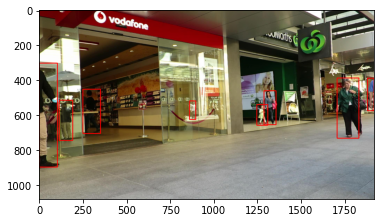

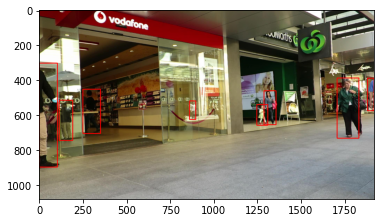

In [114]:
import cv2
import matplotlib.pyplot as plt 
%matplotlib inline

for i in range(len(imgs)):
  for bb in bboxes_with_persons[i]:
    x1, y1, x2, y2 = bb[0], bb[1], bb[2], bb[3]
    cv2.rectangle(imgs[i], (x1,y1), (x2,y2), color=(255, 0, 0), thickness=3)
  plt.imshow(imgs[i])
  plt.show()

Seems like it's working

### Clone SORT

https://github.com/abewley/sort.git

In [30]:
!git clone  https://github.com/abewley/sort.git
!pip install -r sort/requirements.txt

fatal: destination path 'sort' already exists and is not an empty directory.


### Place main code here

You can use this code as a template:

https://github.com/Gan4x4/CV-HSE2019/blob/master/video/exercise.ipynb

In [164]:
import cv2
import time

mot_tracker = Sort() #create instance of SORT
detector = PersonDetector() # YOLOv5 must be inside

# Open video input video

stream = cv2.VideoCapture("/content/MOT17-09-SDP-raw.webm")
fps = stream.get(cv2.CAP_PROP_FPS)
width  = int(stream.get(cv2.CAP_PROP_FRAME_WIDTH))   
height = int(stream.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_video = cv2.VideoWriter('output.mp4',fourcc,fps, (width,height))
max_frames = 400
frames = 0

t_start = time.time()
# Read video frame by frame
while stream.isOpened() and frames < max_frames:
  ret, frame = stream.read() # ret=True if frame loaded
  if ret != True:
    break
  frames += 1

  already_tracked = []
  detections = detector(frame)
  if len(detections) == 0 or detections[0] is None:
    detections.append(np.empty((0, 5)))

  results = mot_tracker.update(np.array(detections[0]))

  if not results is None and len(results) > 0 and not results[0] is None:
      for r in results:
        if r[4] not in already_tracked:
          x1 = int(r[0])
          x2 = int(r[2])
          y1 = int(r[1])
          y2 = int(r[3])
        cv2.rectangle(frame, (x1,y1), (x2,y2),color=(0, 255, 0), thickness=3)
        cv2.putText(frame, str(r[4]), (x1 + 5, y1 + 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        already_tracked.append(r[4])
  out_video.write(frame)

print('Tracking speed: {:.4f} fps'.format((time.time() - t_start) / frames))

# Save video with bounding boxes in `output.mp4` file
stream.release()
out_video.release()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    156928  models.common.C3                        [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                   

Adding autoShape... 
Tracking speed: 0.3597 fps


## Test speed of your code , and place brief conclusion here:

I tetsed model on 400 frames

Avreage speed is 0.3597 fps, or about 2.78 seconds per frame

Printing some frames in case video is unavaliable (first 10 and then each 30th)

In [168]:
from google.colab.patches import cv2_imshow

stream = cv2.VideoCapture("/content/output.mp4")

frames = 0

while stream.isOpened():
  ret, frame = stream.read()
  if ret == False:
    break
  frames += 1 
  if frames <= 10 or frames % 30 == 0:
    cv2_imshow(frame)

Output hidden; open in https://colab.research.google.com to view.